##Investigating the Impact of LSTM Units on EEG Classification Performance

### Summary Experiment:
**This experiment aims to investigate the influence of varying the number of LSTM units on the performance of EEG classification models. A sequential LSTM model architecture is employed, consisting of an LSTM layer followed by batch normalization, dropout, and dense layers. The number of LSTM units is systematically varied to observe its effects on classification accuracy.**

The experiment trains and evaluates a total of 8 models for EEG classification using different number of LSTM units.

The experiment utilizes cross-validation to ensure robust evaluation of the model performance. Multiple folds are created, and the model is trained and evaluated on each fold. Training histories, including loss, accuracy, validation loss, and validation accuracy, are logged for analysis.

By training the models with binary cross-entropy loss and Adam optimizer, the experiment captures the relationship between the number of LSTM units and the resulting accuracy. The fold accuracies and average accuracy across all folds are recorded and analyzed. Additionally, loss and accuracy plots are generated to visualize the training progress and performance of each LSTM unit configuration.

This experiment aims to provide insights into the optimal number of LSTM units for EEG classification tasks, facilitating the development of more accurate and efficient models for EEG analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ED_Experiments/ED_RNN_E06
%ls

/content/drive/MyDrive/ED_Experiments/ED_RNN_E06
model_lstm_unit_8_fold_1.h5


## Import libraries

In [ ]:
import sys
import os
import logging


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


In [ ]:
## seed
np.random.seed(2023)

### Reading CSV data

In [ ]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [ ]:
raw_data

Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  \
0      X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   
1      X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   
2         X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57   
3       X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   
4       X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
11495  X22.V1.114  -22  -22  -23  -26  -36  -42  -45  -42  -45  ...    15   
11496  X19.V1.354  -47  -11   28   77  141  211  246  240  193  ...   -65   
11497    X8.V1.28   14    6  -13  -16   10   26   27   -9    4  ...   -65   
11498  X10.V1.932  -40  -25   -9  -12   -2   12    7   19   22  ...   121   
11499  X16.V1.210   29   41   57   72   74   62   54   43   31  ...   -59   

       X171  X172  X173  X174  X175  X176  X177  X178  y  
0       -15   -31   -77  -103  -127  -116   -83   -51  4  
1       150   146   152   157   156   154   143   129  1  
2        64    48    19   -12   -30   -35   -35   -36  5  
3       -81   -80   -77   -85   -77   -72   -69   -65  5  
4         2   -12   -32   -41   -65   -83   -89   -73  5  
...     ...   ...   ...   ...   ...   ...   ...   ... ..  
11495    16    12     5    -1   -18   -37   -47   -48  2  
11496   -33    -7    14    27    48    77   117   170  1  
11497   -48   -61   -62   -67   -30    -2    -1    -8  5  
11498   135   148   143   116    86    68    59    55  3  
11499   -25    -4     2     5     4    -2     2    20  4  

[11500 rows x 180 columns]

In [ ]:
raw_data.values.shape

(11500, 180)

In [ ]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [ ]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [ ]:
# let's see the type
type(data)

numpy.ndarray

### Classifying data categories as it mentioned in the paper

In [ ]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [ ]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

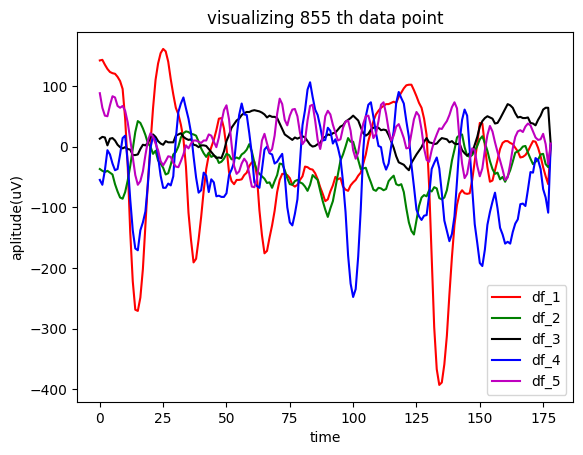

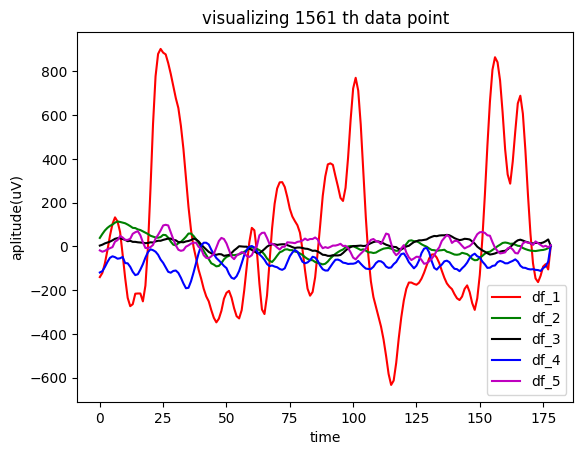

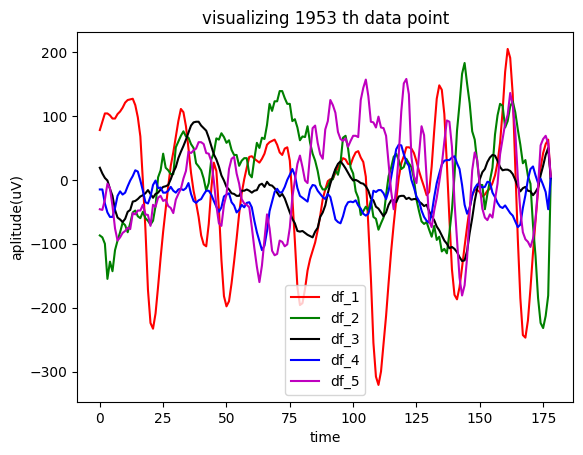

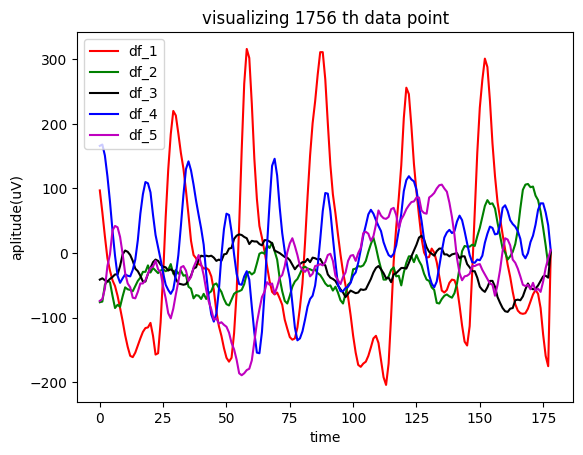

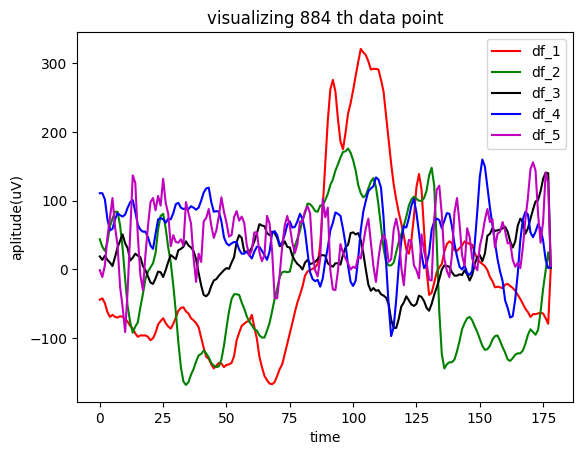

In [ ]:
### all categories
visualize_eeg(5)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [ ]:
all_data = data.copy().astype('int')

In [ ]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [ ]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [ ]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Plot functions

### function to plot loss curve of the
- (training and validation loss) and
- (training and validation accuracy)


In [ ]:
def plot_loss_accuracy(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['loss'], 'b-')
    ax[0].plot(history.history['val_loss'], 'r-')
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].set_title('Loss curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss %')

    ax[1].plot(history.history['accuracy'], 'b-')
    ax[1].plot(history.history['val_accuracy'], 'r-')
    ax[1].legend(['train_accuracy', 'val_accuracy'])
    ax[1].set_title('Accuracy curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy %')

    plt.suptitle(title)
    plt.savefig(title + '.png')

    plt.show()

## Cross Validation initiation and Data Proccessing

In [ ]:
# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [ ]:
def input_output_data(data, random_state=2023):

    X = all_data[:, :-1]
    y = all_data[:, -1]

    return X, y

X, y = input_output_data(data)

In [ ]:
def process_input(X, y, train_index, val_index):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    input_shape = (X_train.shape[1], 1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')


    return X_train, X_val, y_train, y_val, input_shape

## Logger setup

In [ ]:
import absl.logging
import sys
import logging
absl.logging.set_verbosity(absl.logging.ERROR)
absl.logging.set_verbosity(absl.logging.INFO)

In [ ]:
def init_logger(log_file, log_level=logging.INFO, stdout=True):
    logger = logging.getLogger()
    logger.setLevel(log_level)

    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    if stdout:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    return logger


## Let's experiment with LSTM units

`lstm_units = [8, 16, 32, 64, 128, 256, 512, 1024]`

In [ ]:
# class eegClassifier(keras.Model):
#     def __init__(self, input_shape, lstm_units=128):
#         super(eegClassifier, self).__init__()

#         self.lstm = LSTM(units=lstm_units)

#         self.bn = BatchNormalization()
#         self.dropout = Dropout(0.3)

#         self.dense_1 = Dense(units=32, activation='relu')
#         self.dense_2 = Dense(units=64, activation='relu')
#         self.output_layer = Dense(units=1, activation='sigmoid')


#     def call(self, inputs):
#         x = self.dropout(self.lstm(inputs))
#         x = self.bn(self.dropout(self.dense_1(x)))
#         x = self.dropout(self.dense_2(x))
#         x = self.output_layer(x)

#         return x



In [ ]:
def create_sequential_eeg_model(input_shape, lstm_units=128):
    model = keras.Sequential()

    model.add(layers.LSTM(units=lstm_units, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    return model




---- fold = 1 ---- lstm unit = 8--------------

72/72 [==============================] - 0s 5ms/step - loss: 0.1992 - accuracy: 0.9278
model_lstm_unit = 8 Fold = 1 accuracy: 0.9278261065483093


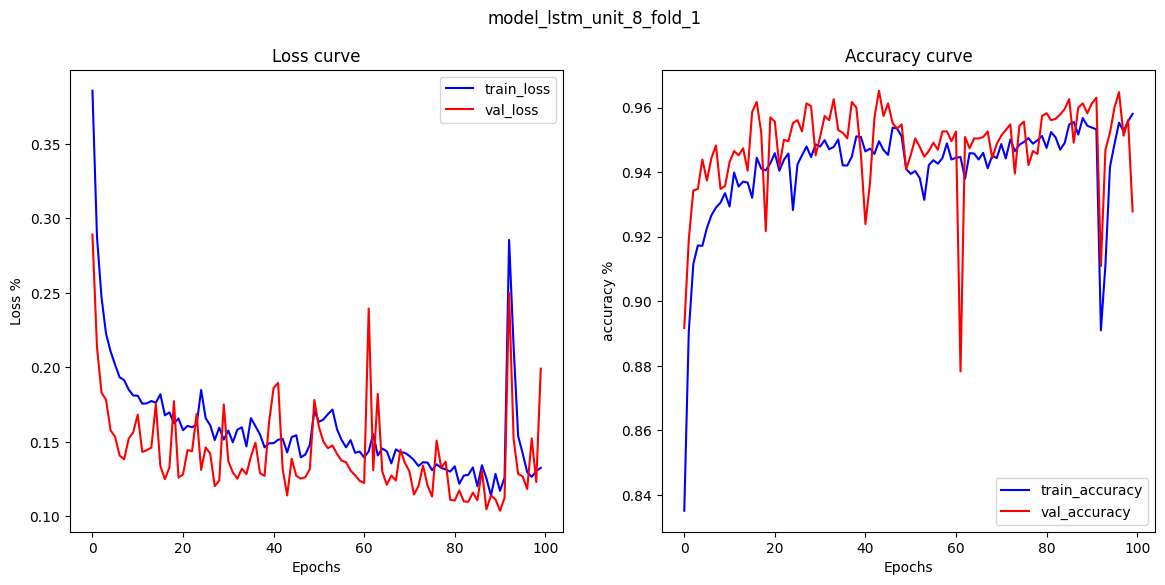



---- fold = 2 ---- lstm unit = 8--------------

72/72 [==============================] - 0s 6ms/step - loss: 0.1105 - accuracy: 0.9639
model_lstm_unit = 8 Fold = 2 accuracy: 0.9639130234718323


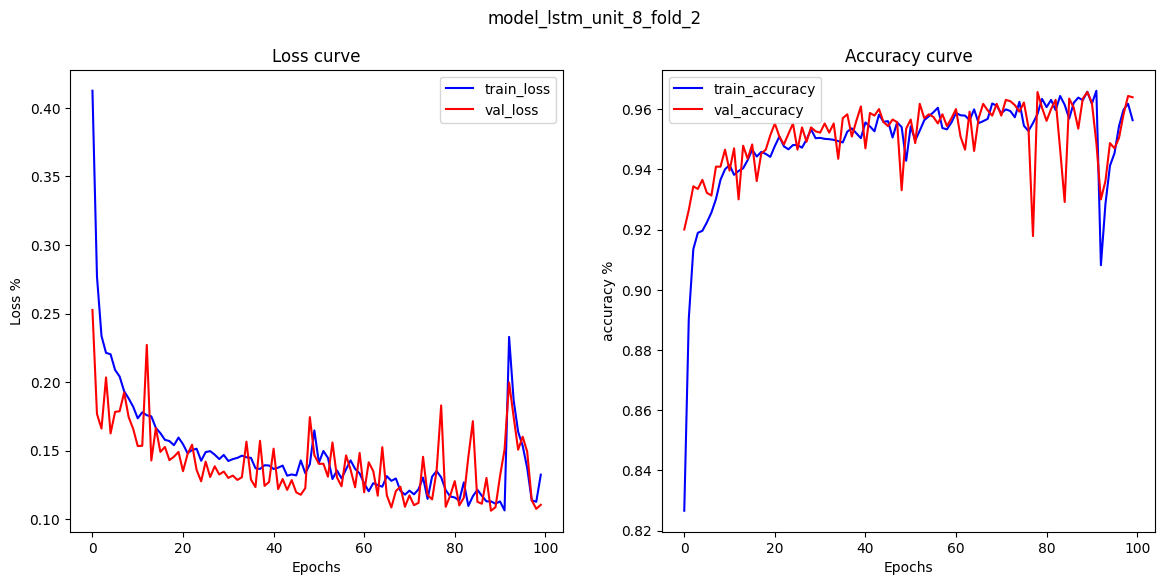



---- fold = 3 ---- lstm unit = 8--------------

72/72 [==============================] - 0s 6ms/step - loss: 0.0764 - accuracy: 0.9817
model_lstm_unit = 8 Fold = 3 accuracy: 0.9817391037940979


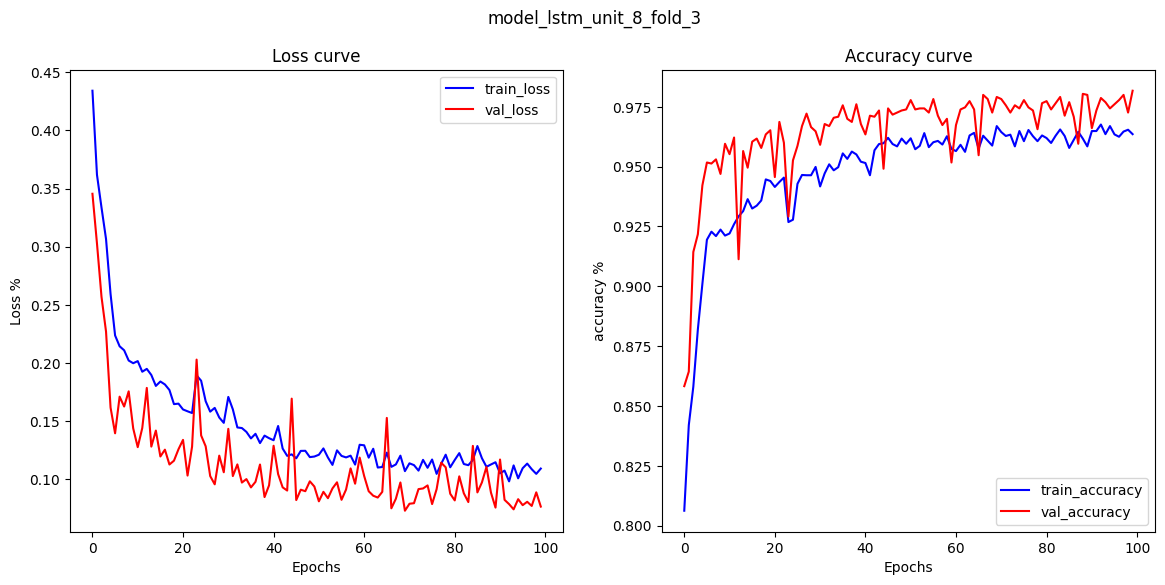



---- fold = 4 ---- lstm unit = 8--------------

72/72 [==============================] - 0s 6ms/step - loss: 0.1314 - accuracy: 0.9535
model_lstm_unit = 8 Fold = 4 accuracy: 0.9534782767295837


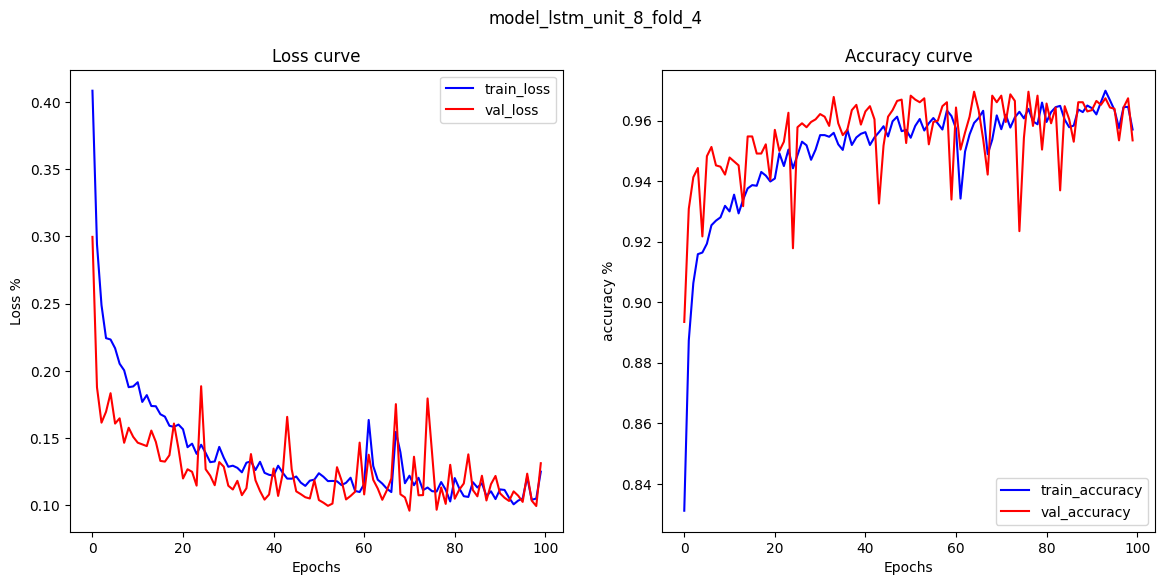



---- fold = 5 ---- lstm unit = 8--------------

72/72 [==============================] - 1s 7ms/step - loss: 0.1227 - accuracy: 0.9535
model_lstm_unit = 8 Fold = 5 accuracy: 0.9534782767295837


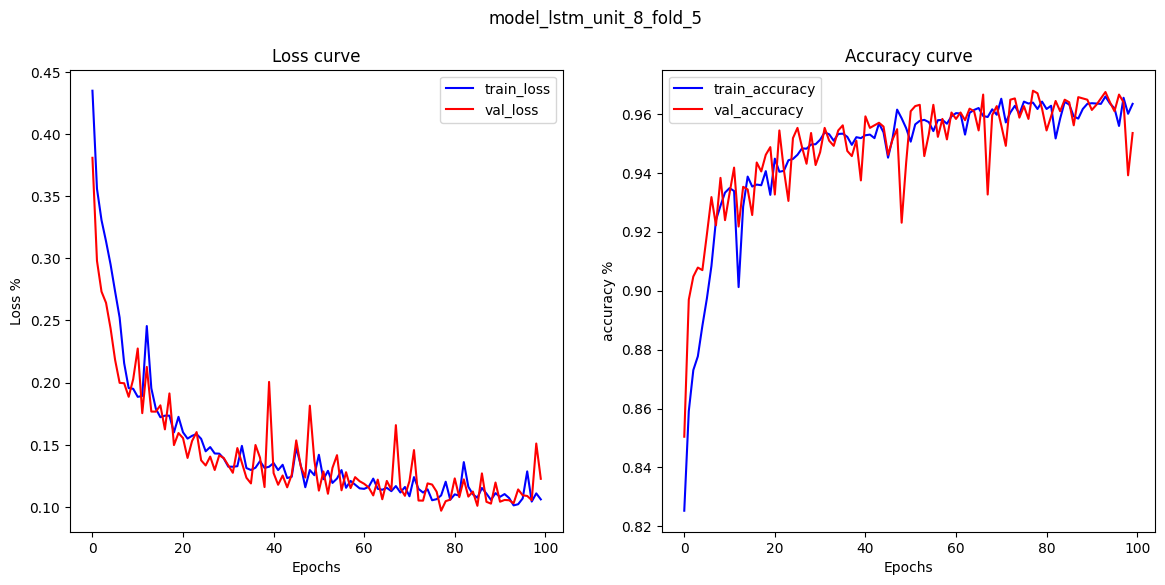

Mean Accuracy: 0.9560869574546814


---- fold = 1 ---- lstm unit = 16--------------

72/72 [==============================] - 0s 6ms/step - loss: 0.0738 - accuracy: 0.9743
model_lstm_unit = 16 Fold = 1 accuracy: 0.9743478298187256


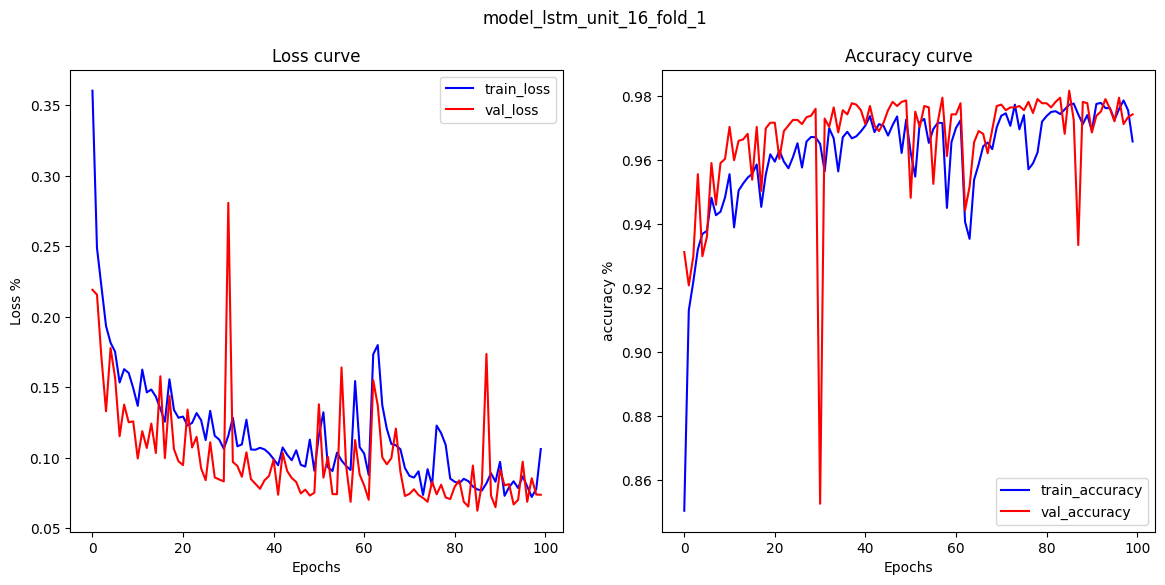



---- fold = 2 ---- lstm unit = 16--------------

72/72 [==============================] - 0s 6ms/step - loss: 0.0703 - accuracy: 0.9778
model_lstm_unit = 16 Fold = 2 accuracy: 0.9778260588645935


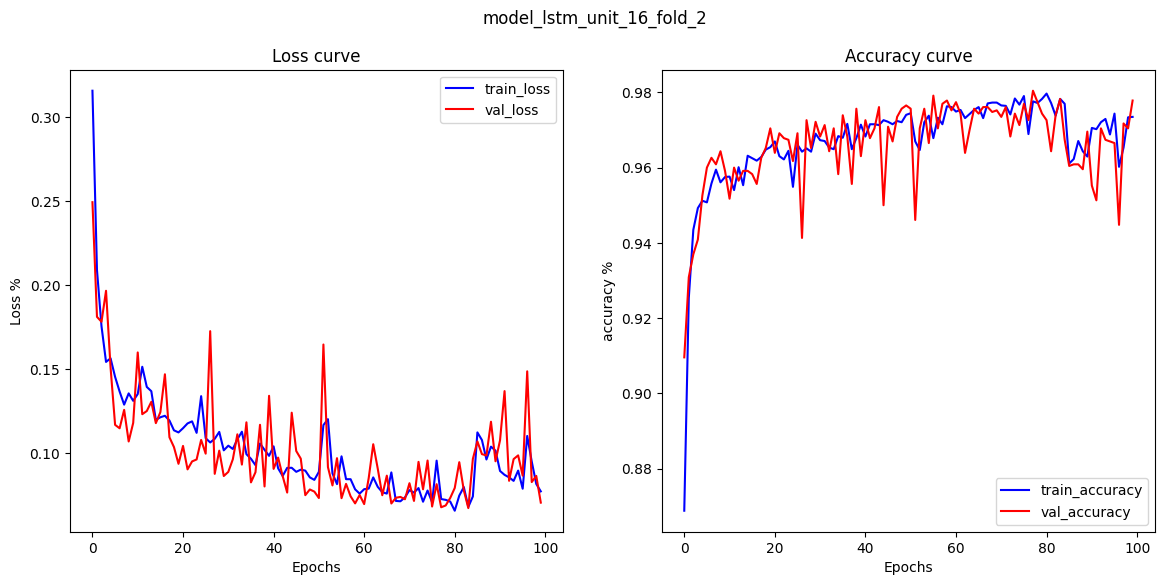



---- fold = 3 ---- lstm unit = 16--------------

72/72 [==============================] - 0s 6ms/step - loss: 0.0733 - accuracy: 0.9730
model_lstm_unit = 16 Fold = 3 accuracy: 0.9730435013771057


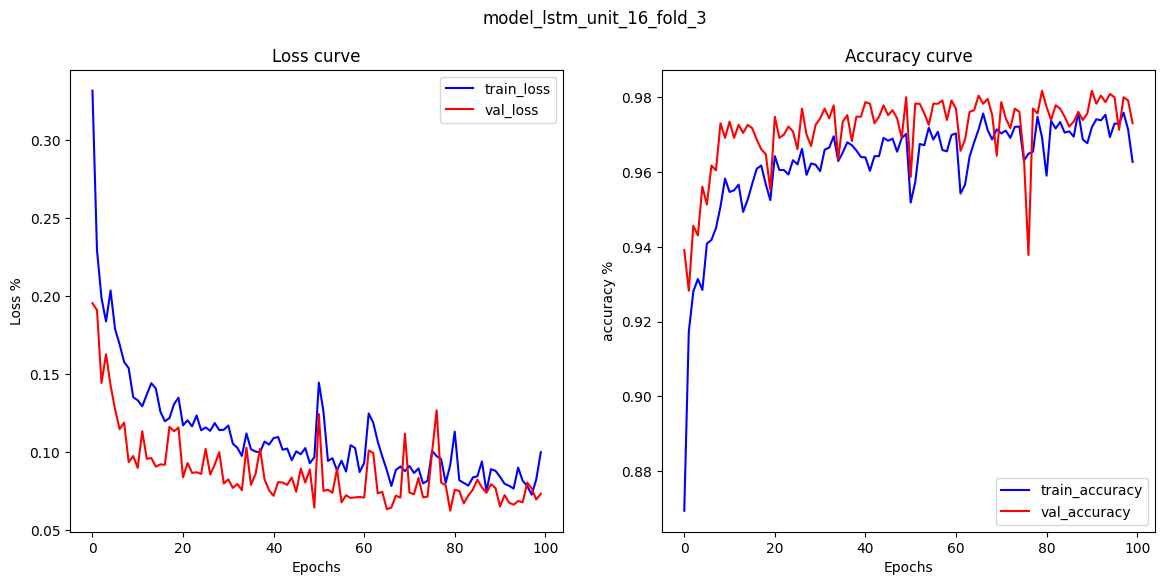



---- fold = 4 ---- lstm unit = 16--------------

72/72 [==============================] - 0s 6ms/step - loss: 0.1363 - accuracy: 0.9604
model_lstm_unit = 16 Fold = 4 accuracy: 0.9604347944259644


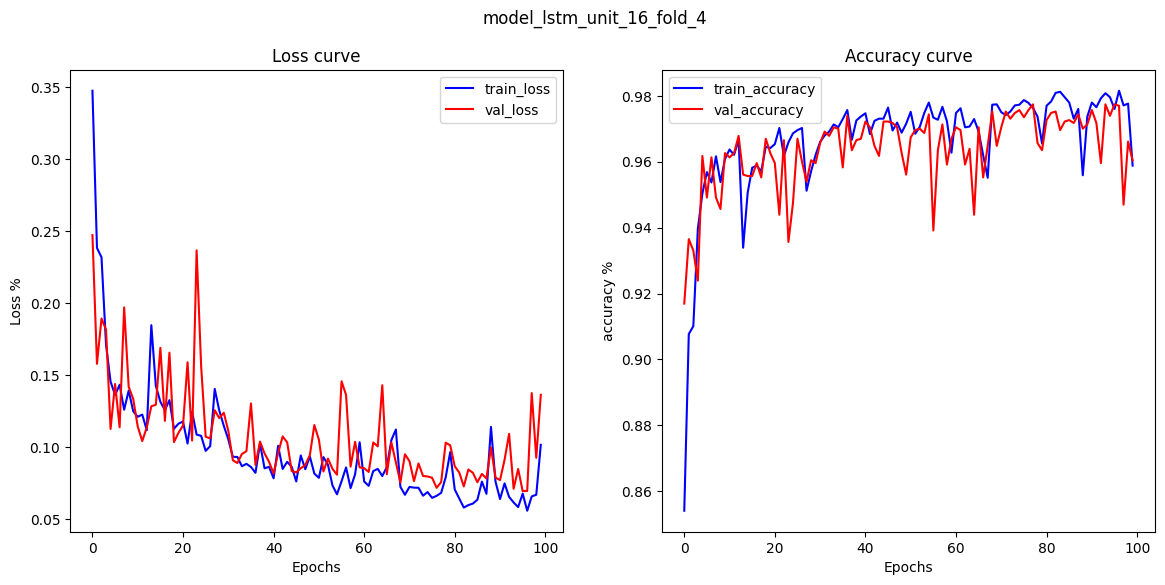



---- fold = 5 ---- lstm unit = 16--------------

72/72 [==============================] - 0s 5ms/step - loss: 0.1003 - accuracy: 0.9704
model_lstm_unit = 16 Fold = 5 accuracy: 0.9704347848892212


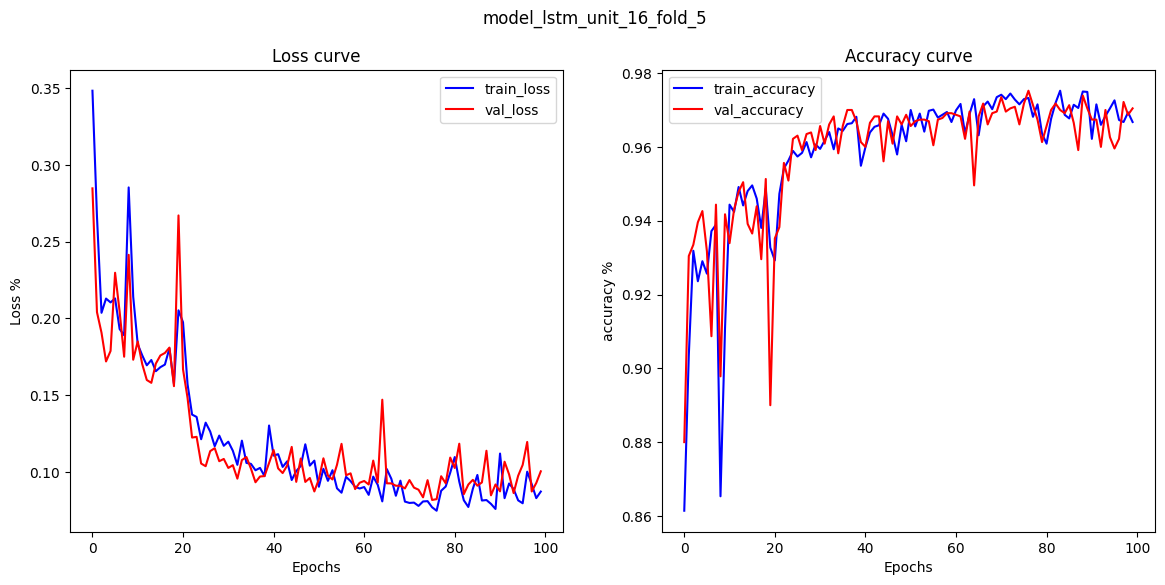

Mean Accuracy: 0.9712173938751221


---- fold = 1 ---- lstm unit = 32--------------

72/72 [==============================] - 1s 7ms/step - loss: 0.0535 - accuracy: 0.9857
model_lstm_unit = 32 Fold = 1 accuracy: 0.9856521487236023


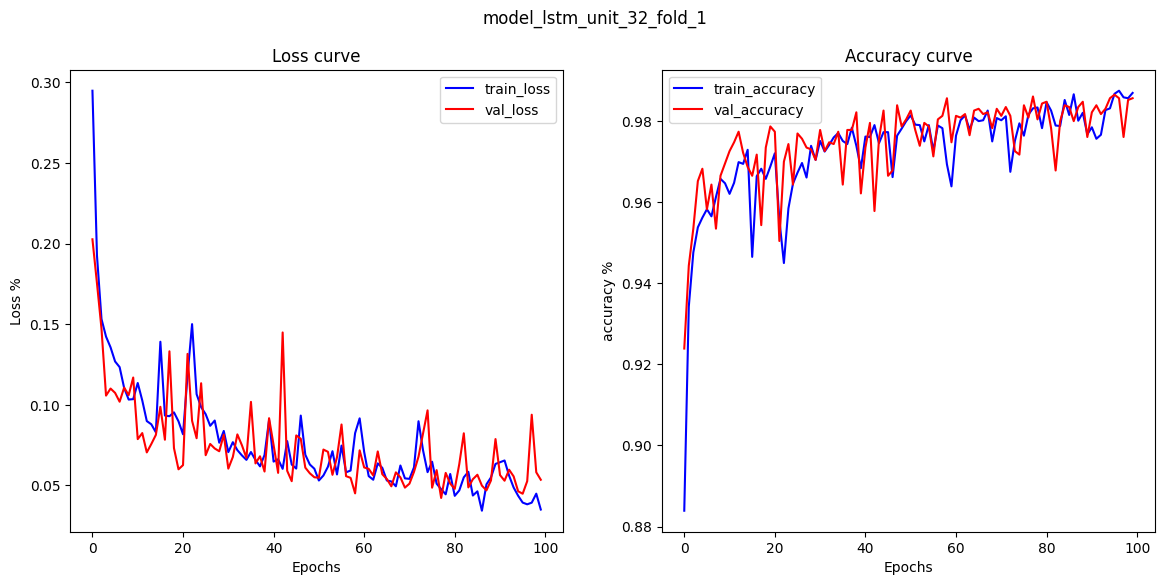



---- fold = 2 ---- lstm unit = 32--------------

72/72 [==============================] - 0s 6ms/step - loss: 0.1174 - accuracy: 0.9596
model_lstm_unit = 32 Fold = 2 accuracy: 0.9595652222633362


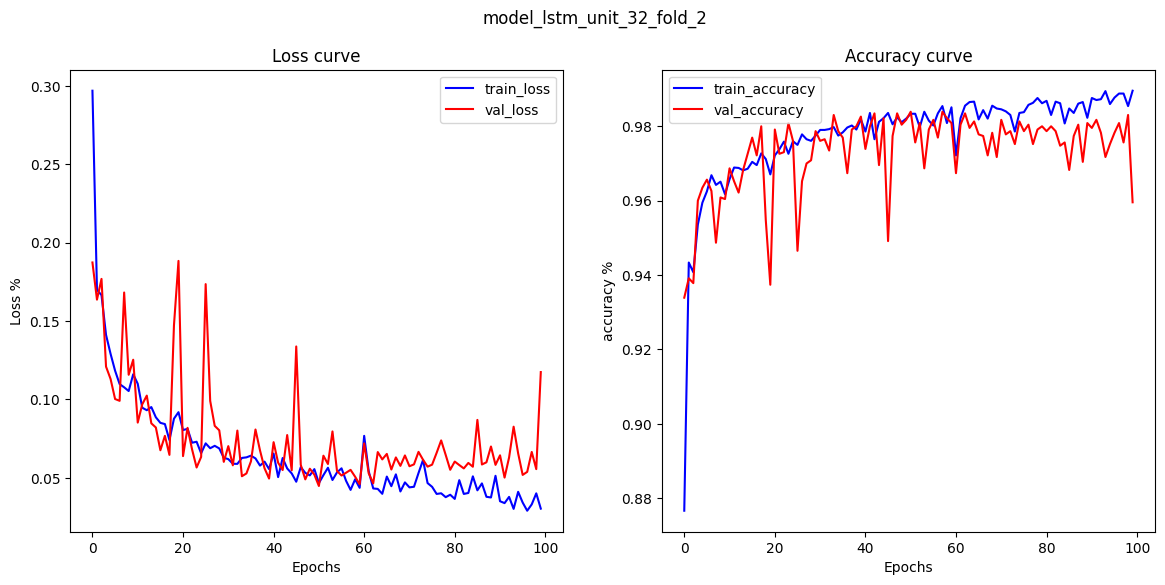



---- fold = 3 ---- lstm unit = 32--------------

72/72 [==============================] - 1s 7ms/step - loss: 0.0449 - accuracy: 0.9848
model_lstm_unit = 32 Fold = 3 accuracy: 0.9847826361656189


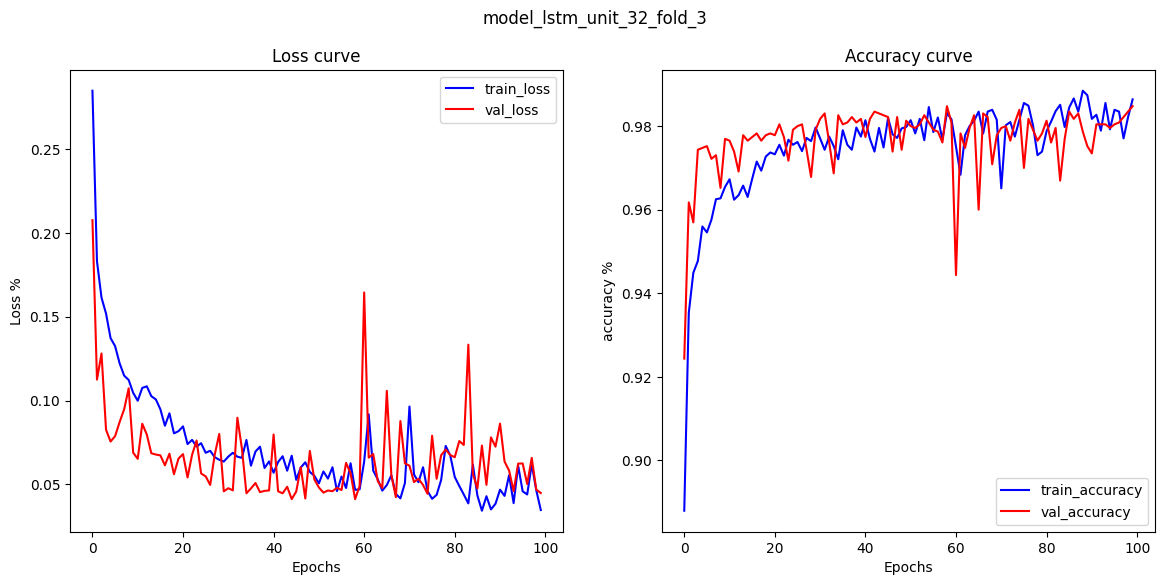



---- fold = 4 ---- lstm unit = 32--------------

72/72 [==============================] - 0s 5ms/step - loss: 0.0789 - accuracy: 0.9774
model_lstm_unit = 32 Fold = 4 accuracy: 0.9773913025856018


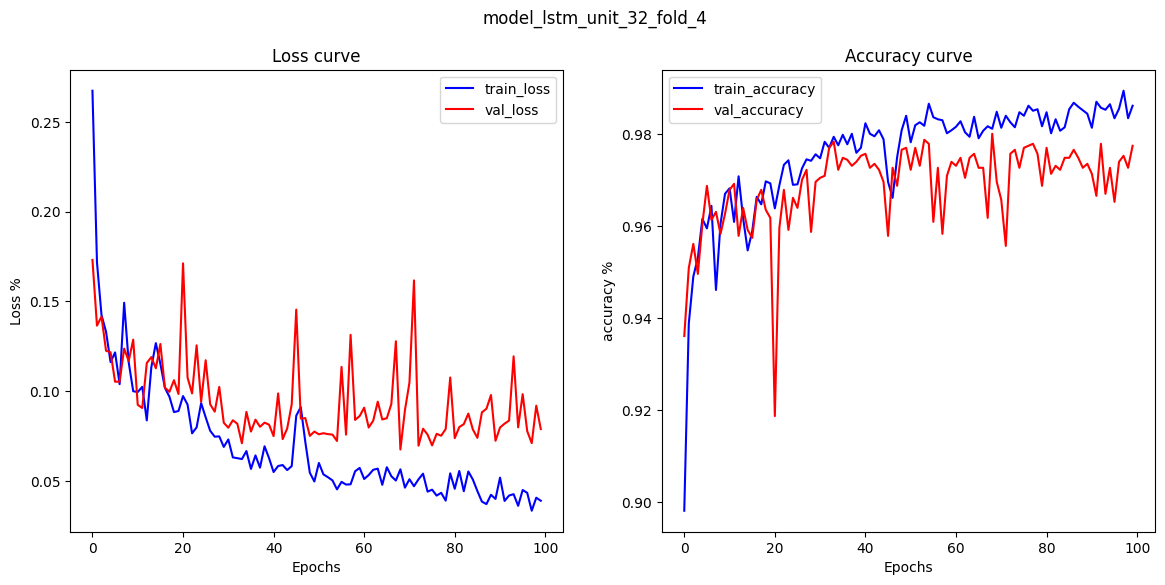



---- fold = 5 ---- lstm unit = 32--------------

72/72 [==============================] - 1s 7ms/step - loss: 0.0809 - accuracy: 0.9774
model_lstm_unit = 32 Fold = 5 accuracy: 0.9773913025856018


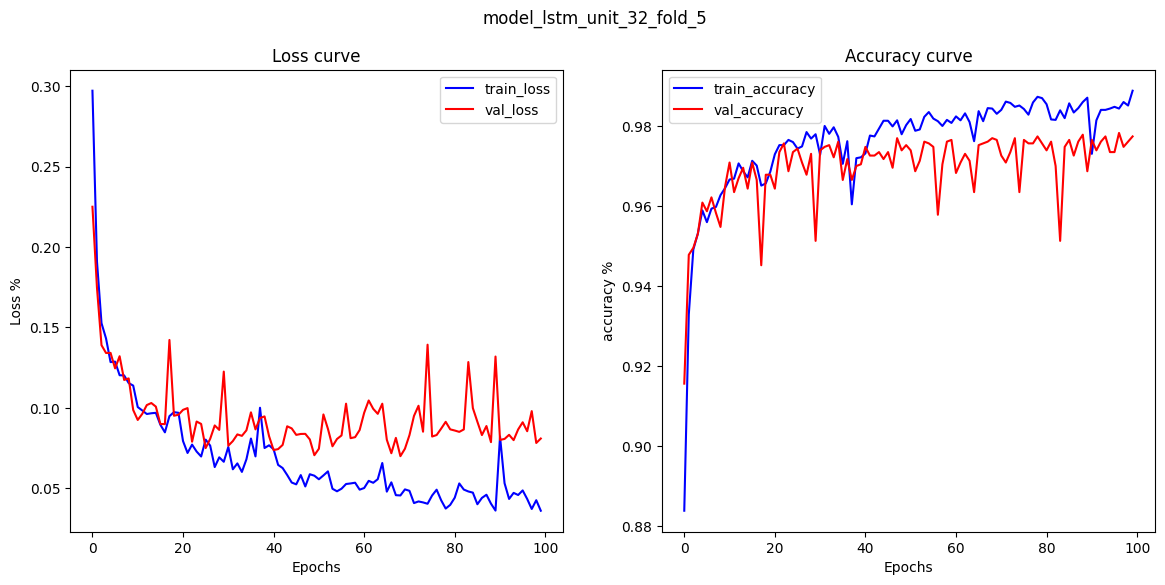

Mean Accuracy: 0.9769565224647522


---- fold = 1 ---- lstm unit = 64--------------

72/72 [==============================] - 1s 7ms/step - loss: 0.0695 - accuracy: 0.9800
model_lstm_unit = 64 Fold = 1 accuracy: 0.9800000190734863


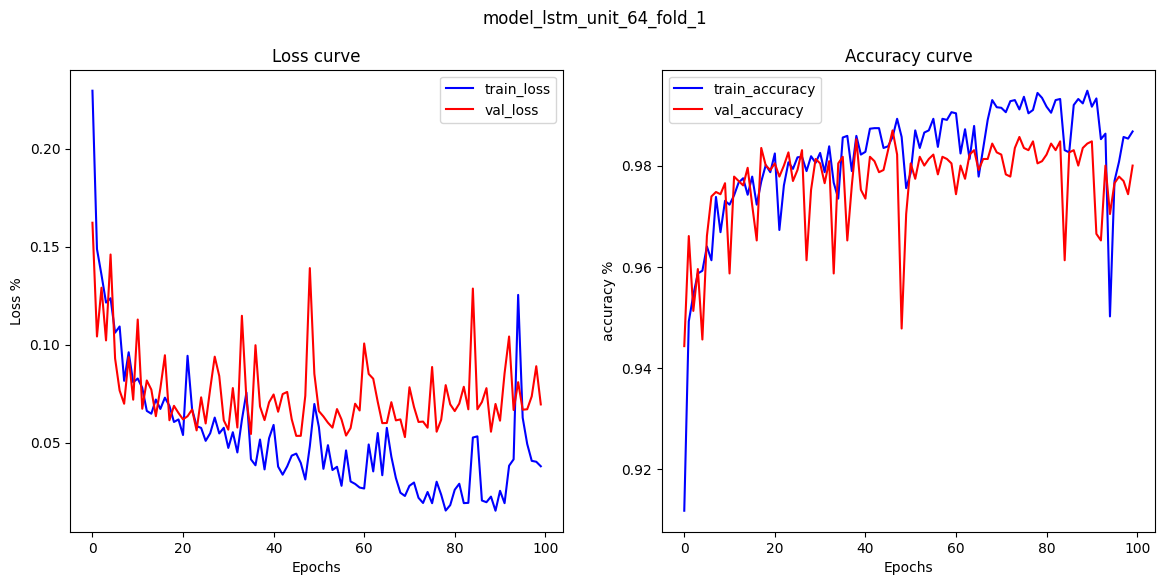



---- fold = 2 ---- lstm unit = 64--------------

72/72 [==============================] - 0s 5ms/step - loss: 0.0604 - accuracy: 0.9826
model_lstm_unit = 64 Fold = 2 accuracy: 0.9826086759567261


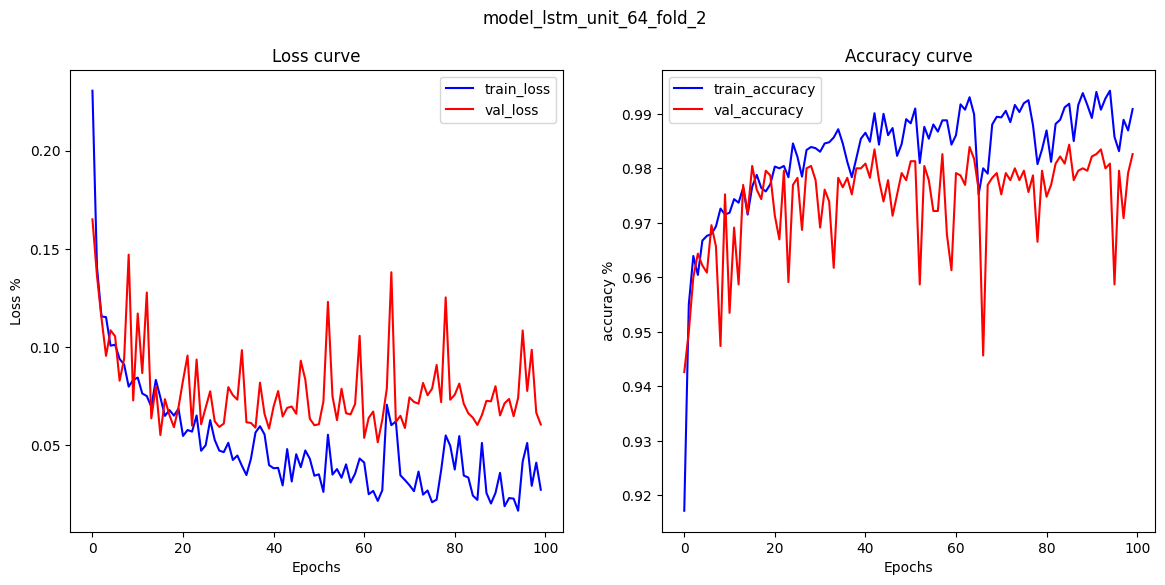



---- fold = 3 ---- lstm unit = 64--------------

72/72 [==============================] - 1s 8ms/step - loss: 0.0585 - accuracy: 0.9852
model_lstm_unit = 64 Fold = 3 accuracy: 0.9852173924446106


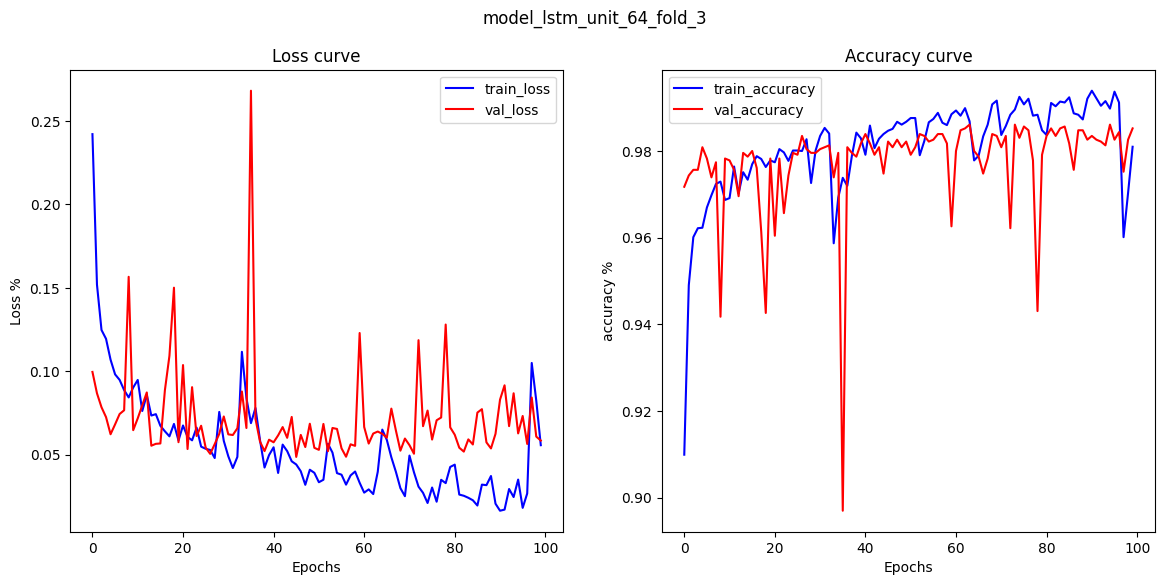



---- fold = 4 ---- lstm unit = 64--------------

72/72 [==============================] - 1s 8ms/step - loss: 0.0813 - accuracy: 0.9778
model_lstm_unit = 64 Fold = 4 accuracy: 0.9778260588645935


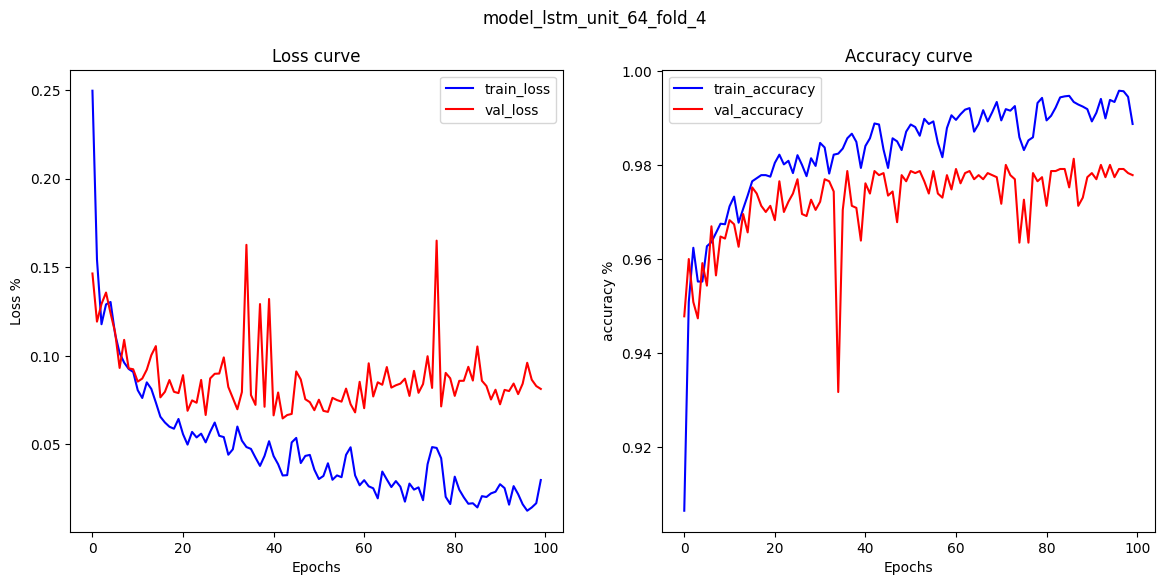



---- fold = 5 ---- lstm unit = 64--------------

72/72 [==============================] - 1s 7ms/step - loss: 0.0831 - accuracy: 0.9765
model_lstm_unit = 64 Fold = 5 accuracy: 0.9765217304229736


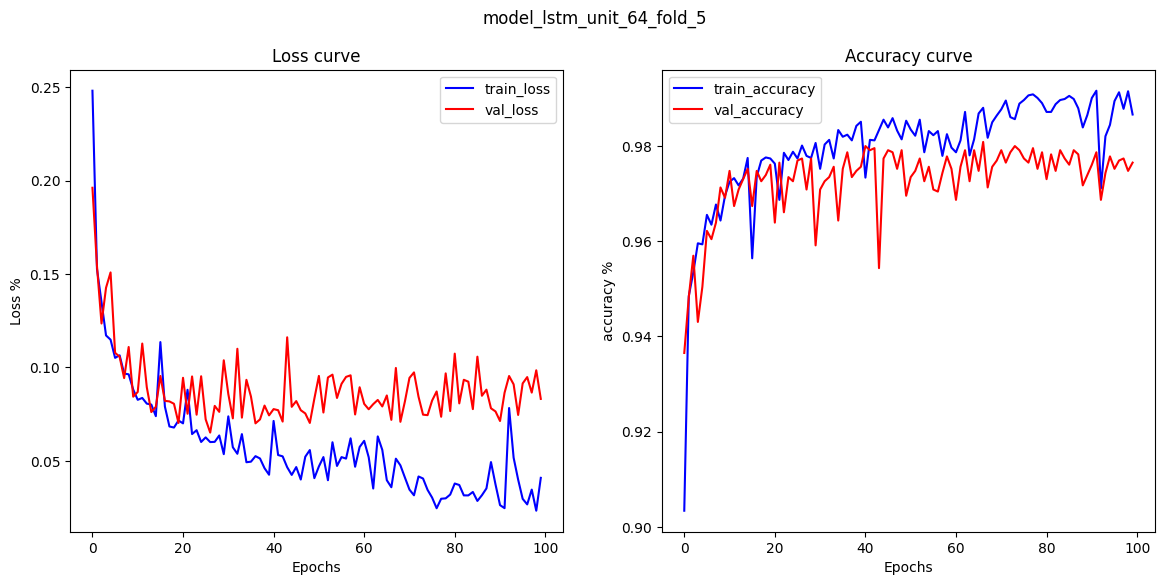

Mean Accuracy: 0.980434775352478


---- fold = 1 ---- lstm unit = 128--------------

72/72 [==============================] - 1s 8ms/step - loss: 0.0656 - accuracy: 0.9857
model_lstm_unit = 128 Fold = 1 accuracy: 0.9856521487236023


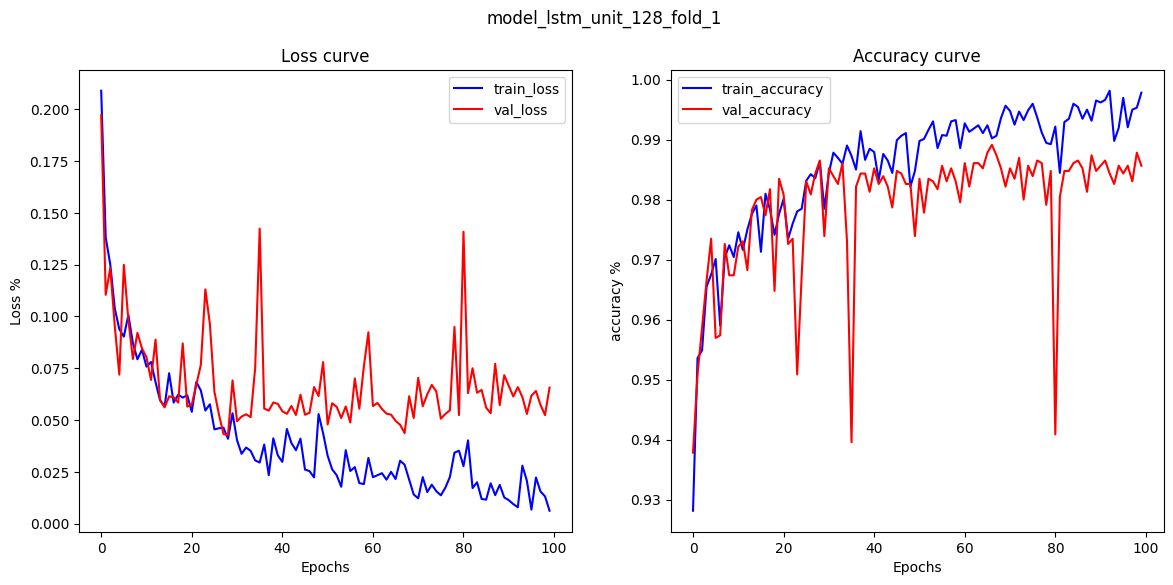



---- fold = 2 ---- lstm unit = 128--------------

72/72 [==============================] - 1s 7ms/step - loss: 0.0618 - accuracy: 0.9830
model_lstm_unit = 128 Fold = 2 accuracy: 0.9830434918403625


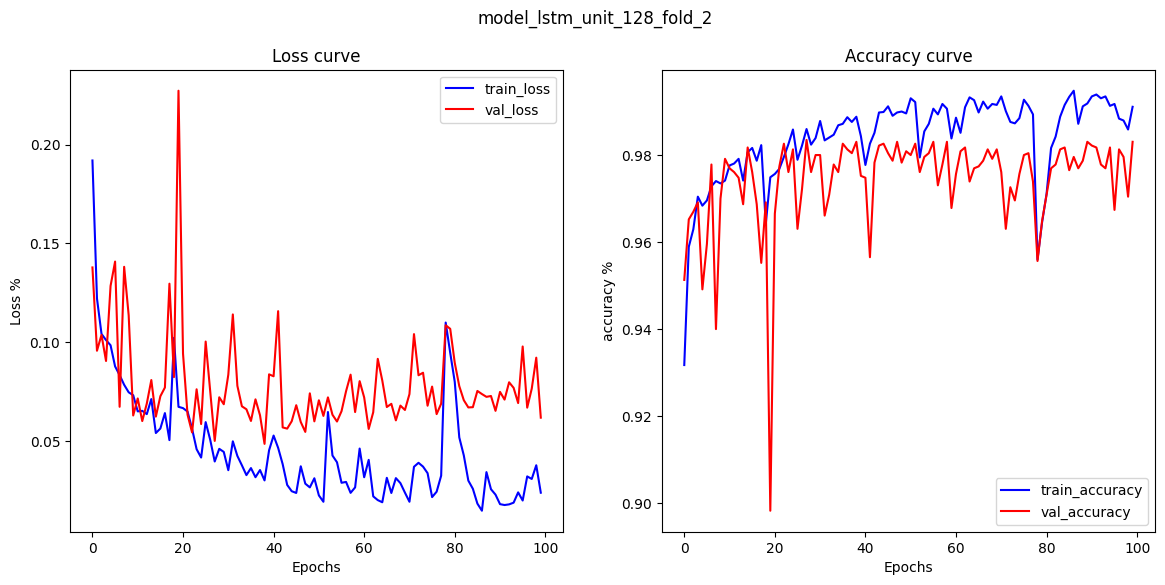



---- fold = 3 ---- lstm unit = 128--------------

72/72 [==============================] - 1s 8ms/step - loss: 0.0582 - accuracy: 0.9830
model_lstm_unit = 128 Fold = 3 accuracy: 0.9830434918403625


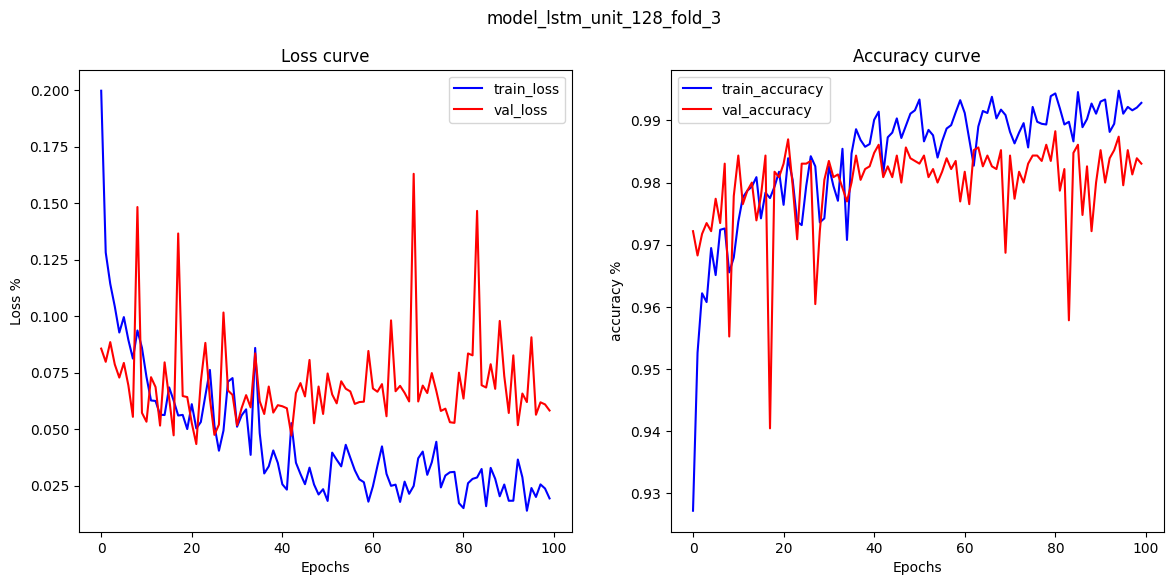



---- fold = 4 ---- lstm unit = 128--------------

72/72 [==============================] - 1s 8ms/step - loss: 0.0979 - accuracy: 0.9800
model_lstm_unit = 128 Fold = 4 accuracy: 0.9800000190734863


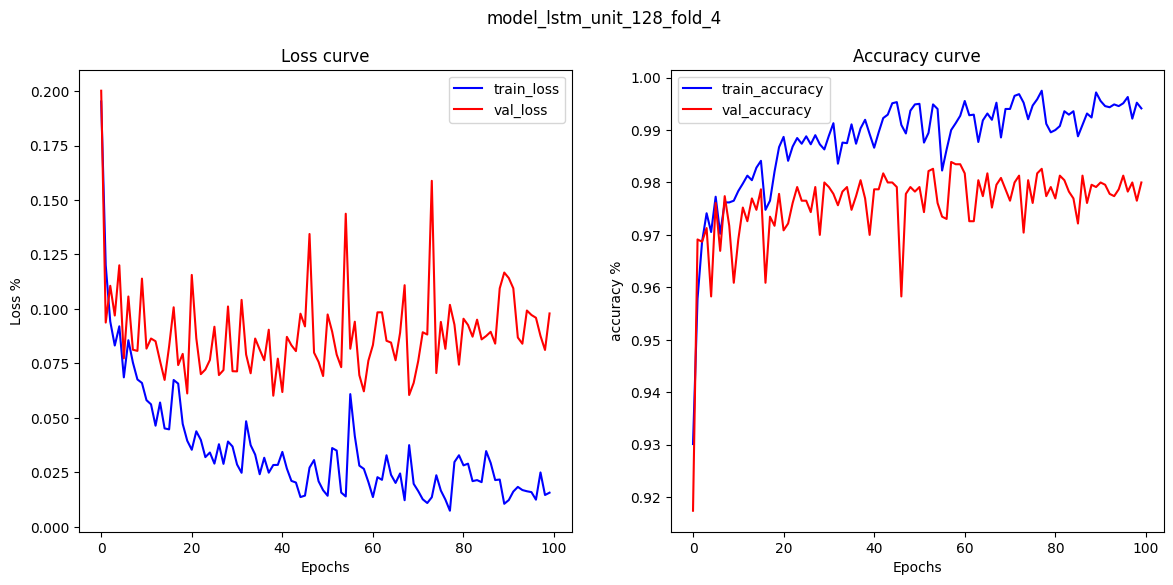



---- fold = 5 ---- lstm unit = 128--------------

72/72 [==============================] - 1s 8ms/step - loss: 0.1068 - accuracy: 0.9761
model_lstm_unit = 128 Fold = 5 accuracy: 0.9760869741439819


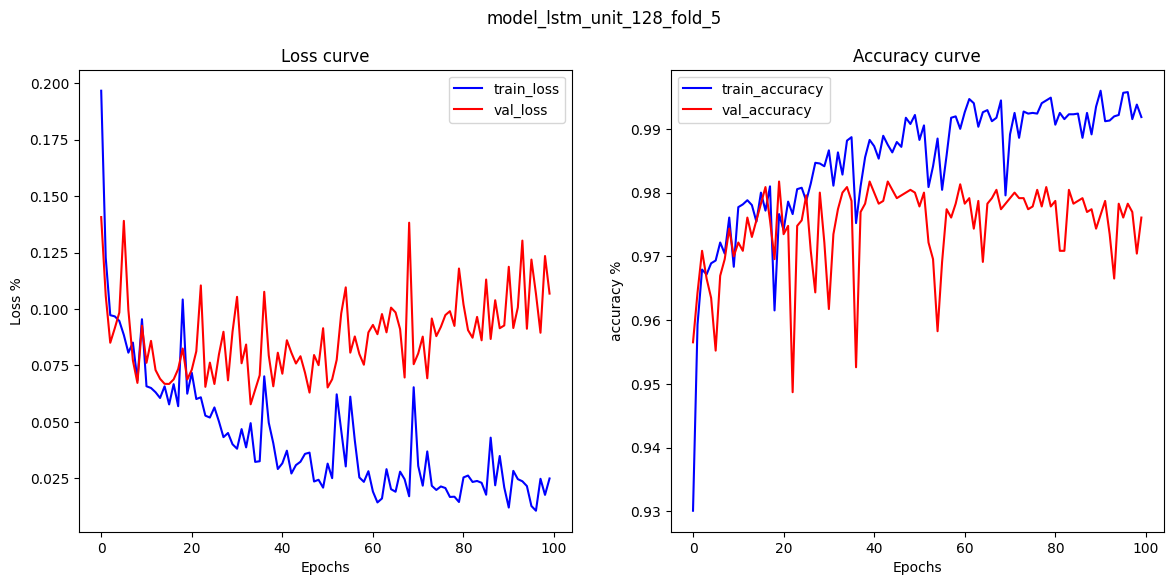

Mean Accuracy: 0.9815652251243592


---- fold = 1 ---- lstm unit = 256--------------

72/72 [==============================] - 1s 7ms/step - loss: 0.0486 - accuracy: 0.9843
model_lstm_unit = 256 Fold = 1 accuracy: 0.9843478202819824


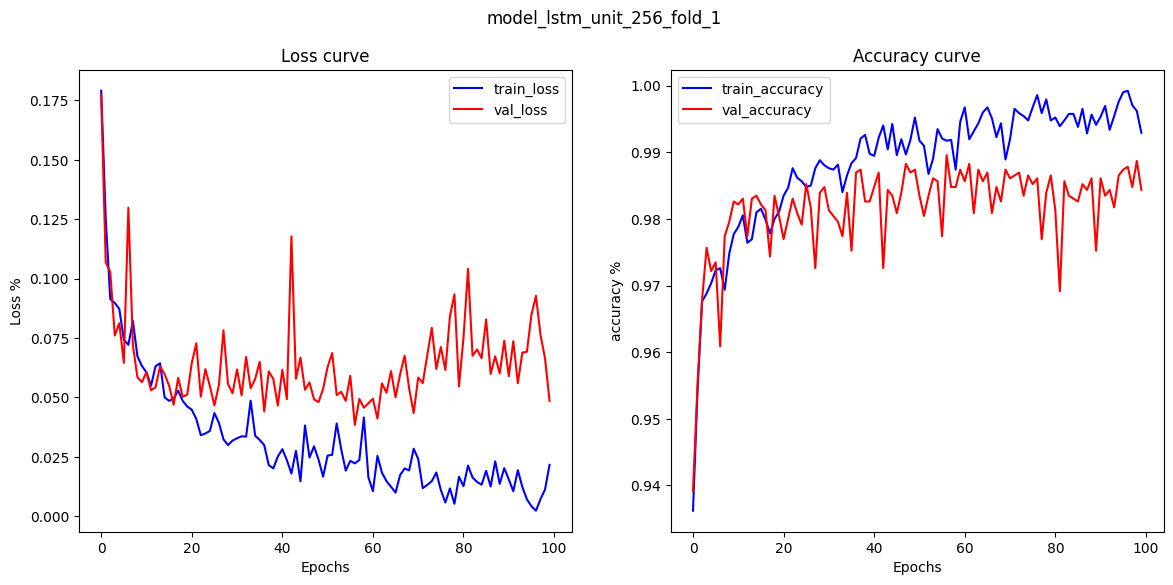



---- fold = 2 ---- lstm unit = 256--------------

72/72 [==============================] - 0s 6ms/step - loss: 0.1087 - accuracy: 0.9774
model_lstm_unit = 256 Fold = 2 accuracy: 0.9773913025856018


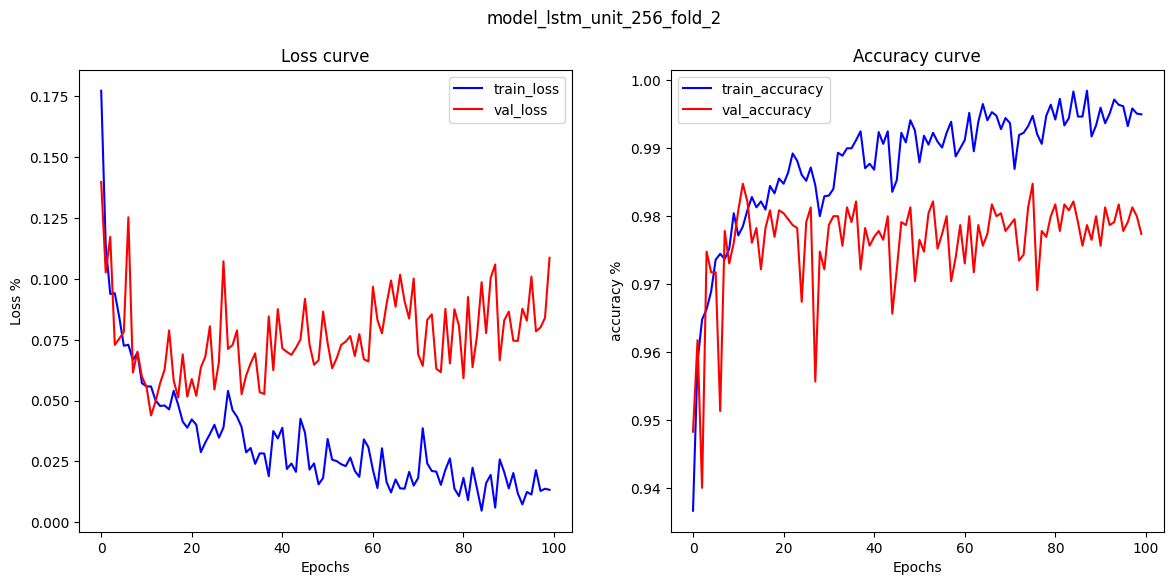



---- fold = 3 ---- lstm unit = 256--------------

72/72 [==============================] - 1s 8ms/step - loss: 0.0526 - accuracy: 0.9857
model_lstm_unit = 256 Fold = 3 accuracy: 0.9856521487236023


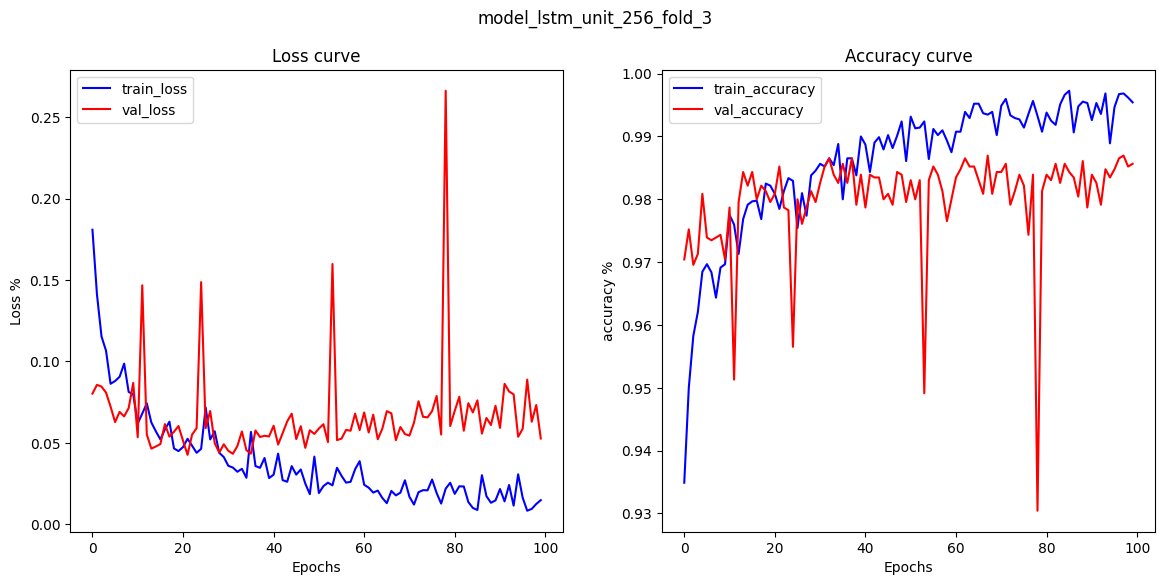



---- fold = 4 ---- lstm unit = 256--------------

72/72 [==============================] - 1s 9ms/step - loss: 0.1149 - accuracy: 0.9809
model_lstm_unit = 256 Fold = 4 accuracy: 0.9808695912361145


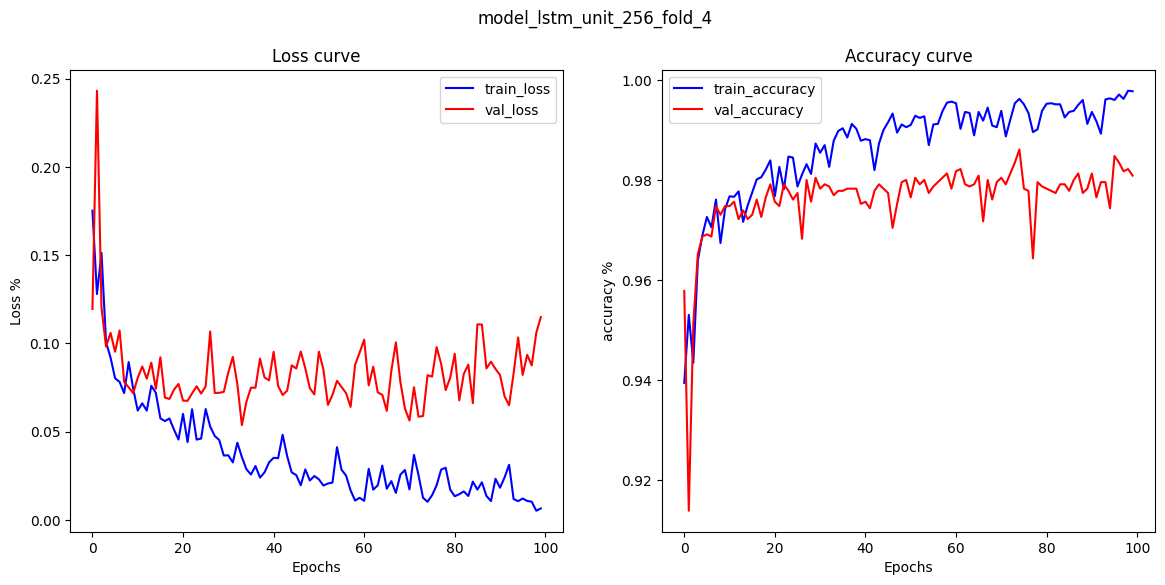



---- fold = 5 ---- lstm unit = 256--------------

72/72 [==============================] - 1s 8ms/step - loss: 0.1362 - accuracy: 0.9757
model_lstm_unit = 256 Fold = 5 accuracy: 0.9756521582603455


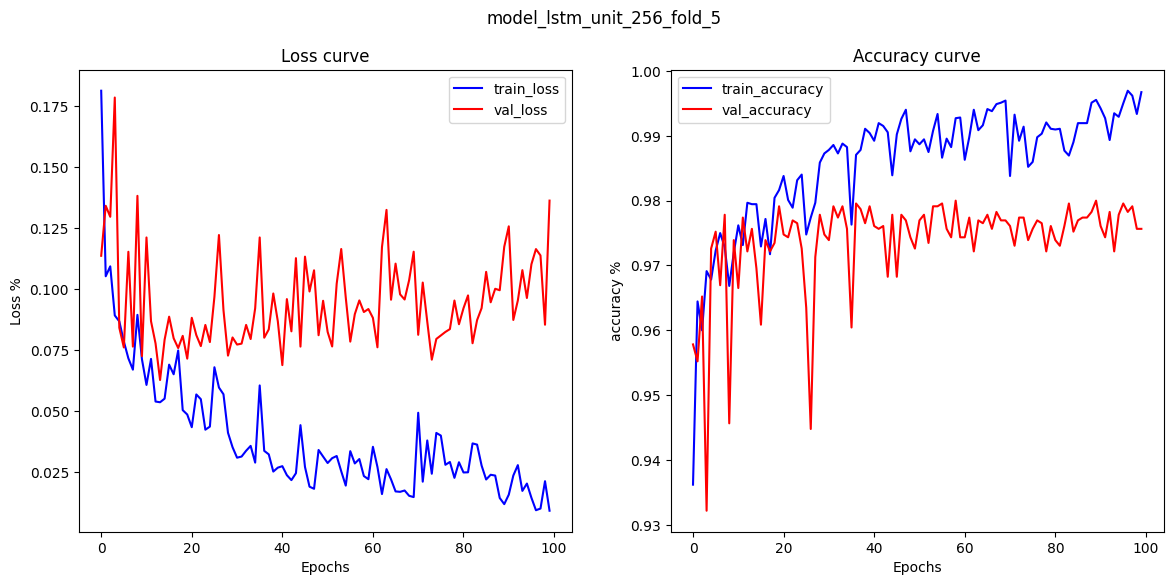

Mean Accuracy: 0.9807826042175293


---- fold = 1 ---- lstm unit = 512--------------

72/72 [==============================] - 1s 12ms/step - loss: 0.0499 - accuracy: 0.9878
model_lstm_unit = 512 Fold = 1 accuracy: 0.9878261089324951


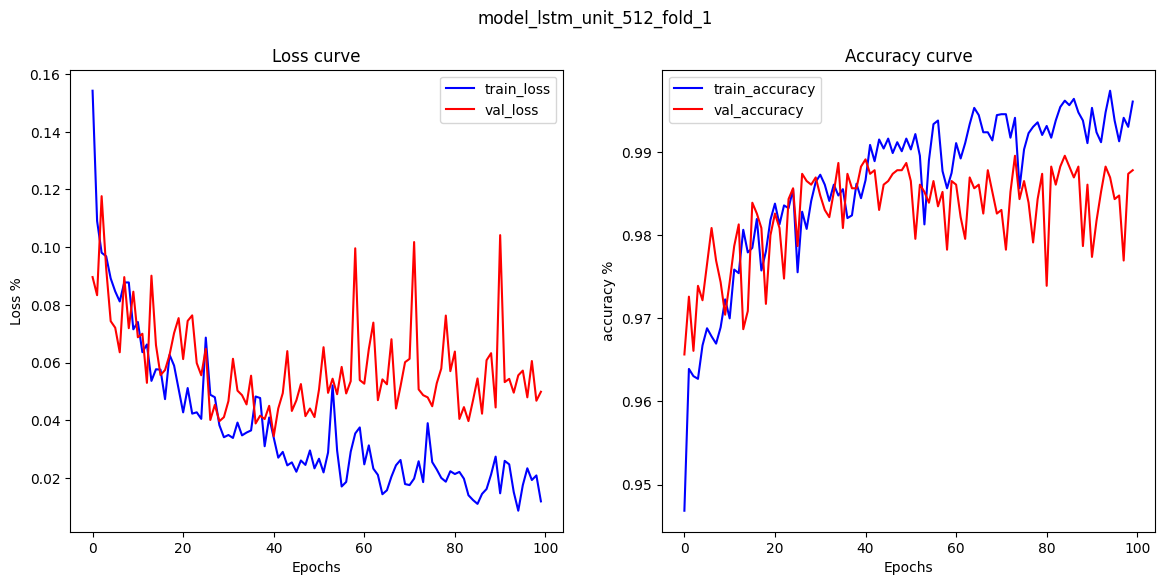



---- fold = 2 ---- lstm unit = 512--------------

72/72 [==============================] - 1s 13ms/step - loss: 0.0663 - accuracy: 0.9817
model_lstm_unit = 512 Fold = 2 accuracy: 0.9817391037940979


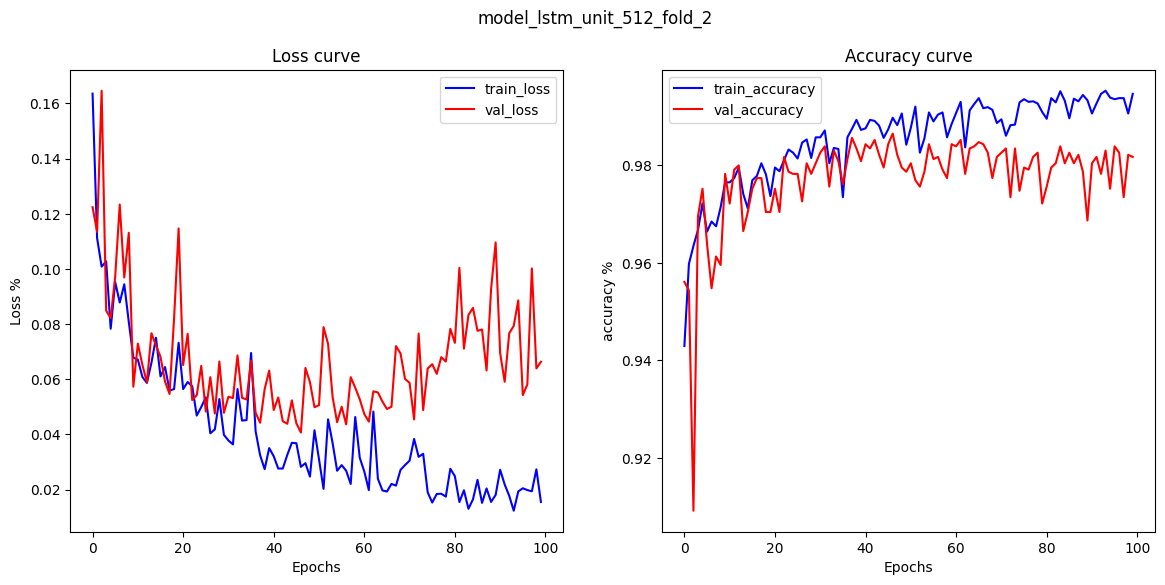



---- fold = 3 ---- lstm unit = 512--------------

72/72 [==============================] - 1s 11ms/step - loss: 0.0515 - accuracy: 0.9874
model_lstm_unit = 512 Fold = 3 accuracy: 0.9873912930488586


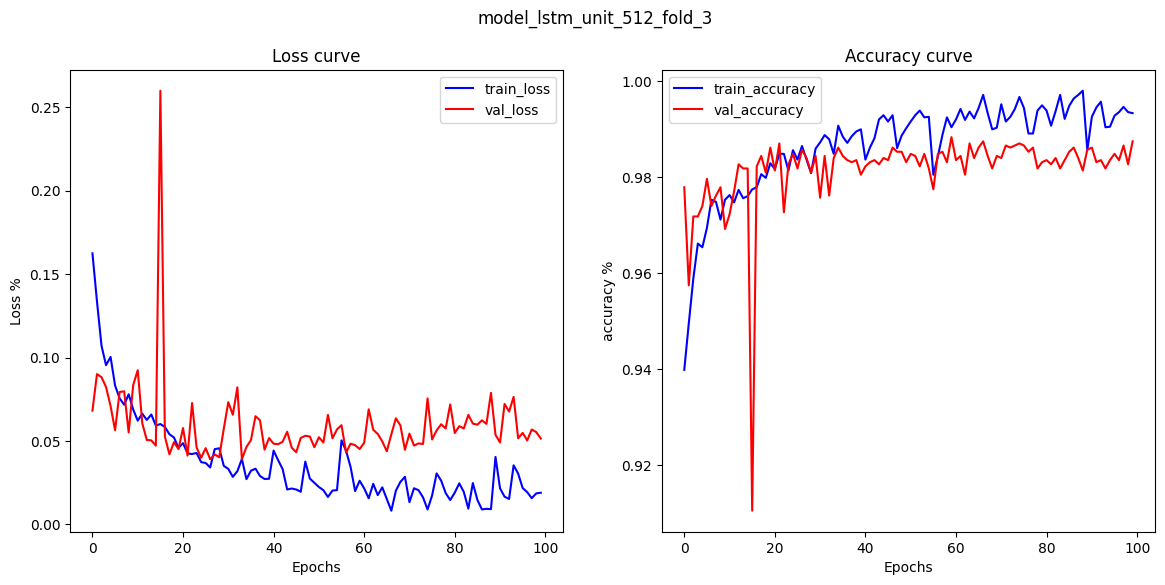



---- fold = 4 ---- lstm unit = 512--------------

72/72 [==============================] - 1s 12ms/step - loss: 0.0995 - accuracy: 0.9783
model_lstm_unit = 512 Fold = 4 accuracy: 0.97826087474823


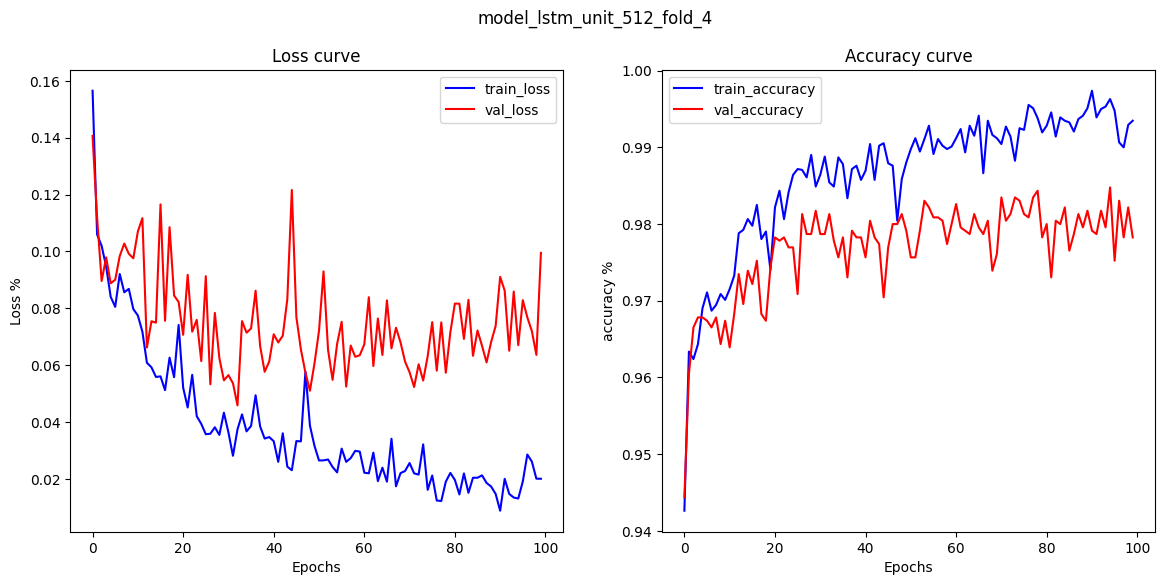



---- fold = 5 ---- lstm unit = 512--------------



In [ ]:
lstm_all_units = [8, 16, 32, 64, 128, 256, 512, 1024]


for lstm_units in lstm_all_units:

    # Perform cross-validation
    fold_accuracy = []
    fold = 1

    for train_index, val_index in skf.split(X, y):
        X_train, X_val, y_train, y_val, input_shape = process_input(X, y, train_index, val_index)


        # model = eegClassifier(input_shape, lstm_units)
        model = create_sequential_eeg_model(input_shape, lstm_units)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        log_file = f"model_lstm_unit_{lstm_units}_fold_{fold}.log"
        model_name = f"model_lstm_unit_{lstm_units}_fold_{fold}.h5"

        # Clear existing log handlers and close log files
        root_logger = logging.getLogger()
        for handler in root_logger.handlers:
            handler.close()
        root_logger.handlers.clear()

        # Create a separate log file for each model
        logger = init_logger(log_file, stdout=False)


        logger.info(f"\n\n---- fold = {fold} ---- lstm unit = {lstm_units}--------------\n")
        print(f"\n\n---- fold = {fold} ---- lstm unit = {lstm_units}--------------\n")

        # Define the checkpoint callback to save the best model
        checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', save_format="h5")

        # Train the model and capture the history
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                            callbacks=[checkpoint], verbose=0)

        # Log loss and accuracy
        for i, (loss, accuracy) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
            logger.info(f"Epoch {i+1} - Loss: {loss} - Accuracy: {accuracy}")
        for i, (val_loss, val_accuracy) in enumerate(zip(history.history['val_loss'], history.history['val_accuracy'])):
            logger.info(f"Epoch {i+1} - Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}")


        # Evaluate the model on the test set
        loss_scale_optimizer, accuracy = model.evaluate(X_val, y_val)
        fold_accuracy.append(accuracy)

        # Log fold accuracy
        logger.info(f"model_lstm_unit = {lstm_units} Fold = {fold} accuracy: {accuracy}")

        print(f"model_lstm_unit = {lstm_units} Fold = {fold} accuracy: {accuracy}")
        plot_loss_accuracy(history, f"model_lstm_unit_{lstm_units}_fold_{fold}")
        # plot_accuracy(history)

        fold += 1

    # Calculate the average accuracy across all folds
    mean_accuracy = np.mean(fold_accuracy)
    print("Mean Accuracy:", mean_accuracy)